In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import itertools

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from tqdm import tqdm
import xgboost as xgb #BDT
import pickle
import mplhep as hep

import concurrent.futures as futures

from utils.analysis import Optimization, PandasAnalysis

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/vbsvvhjets/output_new/Run2/*.root")
babies = [baby for baby in babies if "data" not in baby]
babies

['../analysis/studies/vbsvvhjets/output_new/Run2/TTW.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/TTHad.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/SingleTop.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/QCD.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/TTH.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/Bosons.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/TT1L.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/VBSVVH.root']

In [45]:
vbsvvh = Optimization(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf"
    ]
)

vbsvvh.df["bdt_presel"] = vbsvvh.df.eval(
    "ST > 1300"
    + "and hbbfatjet_score > 0.5"
    + "and ld_vqqfatjet_score > 0.5 and tr_vqqfatjet_score > 0.5"
    + "and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + "and hbbfatjet_mass < 150"
)

with open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/vbsbdt_features.txt", "r") as txt_file:
    features = txt_file.read().splitlines()
bst = pickle.load(open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/vbsbdt.pkl", "rb"))
vbsvvh.df["bdt"] = bst.predict(xgb.DMatrix(vbsvvh.df[features]))

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.15s/it]
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [46]:
from utils.cutflow import CutflowCollection, Cutflow, Cut

cutflows = CutflowCollection(
    cutflows={name: Cutflow() for name in vbsvvh.df.name.unique()}
)

In [47]:
def update_cutflows(selection, cut_name=None):
    global vbsvvh
    global cutflows
    selection_str = PandasAnalysis.get_selection_str(selection)
    for name, cutflow in cutflows.items():
        # Get previous cut
        if len(cutflow) > 0:
            prev_cut = cutflow[cutflow.terminal_cut_names[-1]]
        else:
            prev_cut = Cut("Dummy")
        # Create new cut
        _df = vbsvvh.df[(vbsvvh.df.name == name)]
        n_pass_raw = len(_df)
        n_pass_wgt = _df.event_weight.sum()
        new_cut = Cut(
            cut_name or selection_str,
            n_pass=n_pass_raw,
            n_pass_weighted=n_pass_wgt,
            n_fail=(prev_cut.n_pass - n_pass_raw),
            n_fail_weighted=(prev_cut.n_pass_weighted - n_pass_wgt),
        )
        # Insert new cut
        if len(cutflow) > 0:
            cutflow.insert(prev_cut.name, new_cut)
        else:
            cutflow.set_root_cut(new_cut)
            
    if "TotalBkg" in cutflows.names:
        cutflows.pop("TotalBkg")

    cutflows["TotalBkg"] = cutflows.sum()

    for name in vbsvvh.df[vbsvvh.df.is_data | vbsvvh.df.is_signal].name.unique():
        cutflows["TotalBkg"] -= cutflows[name]

In [48]:
vbsvvh.make_selection("bdt_presel")
vbsvvh.set_split_column(ratio=0.6, name="split")

update_cutflows("bdt_presel")

In [49]:
vbsvvh.make_selection(
    "hbbfatjet_mass > 70"
    + "and ld_vqqfatjet_mass > 50"
    + "and tr_vqqfatjet_mass > 50"
)
update_cutflows("mass_windows")

In [50]:
vbsvvh.get_event_counts()

(9.411909888806784, 598.9678823144479)

In [64]:
scans = {
    "lower": {
        "bdt": np.linspace(0.75, 0.95, 11),
        "hbbfatjet_score": np.linspace(0.5, 0.9, 11),
        "ld_vqqfatjet_score": np.linspace(0.5, 0.9, 11),
        "tr_vqqfatjet_score": np.linspace(0.5, 0.9, 11)
    },
#     "lower": {
#         "hbbfatjet_mass": np.linspace(60, 80, 5),
#         "ld_vqqfatjet_mass": np.linspace(50, 70, 5),
#         "tr_vqqfatjet_mass": np.linspace(50, 70, 5),
#     }
}

cuts = {}
for bound_type, bounds in scans.items():
    for var, wps in bounds.items():
        if var not in cuts:
            cuts[var] = []
        for wp in wps:
            if bound_type == "lower":
                cuts[var].append(f"{var} >= {wp}")
            elif bound_type == "upper":
                cuts[var].append(f"{var} < {wp}")

selections = [" and ".join(combo) for combo in itertools.product(*cuts.values())]

fom = lambda S, B: S/np.sqrt(B) if B > 0 else S/np.sqrt(0.0001)
            
results = []
for sel in tqdm(selections):
    sig, bkg = vbsvvh.get_event_counts(selection=sel)
    results.append((sel, sig, bkg, fom(sig, bkg)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14641/14641 [05:14<00:00, 46.62it/s]


In [65]:
results_df = pd.DataFrame(
    {
        "selection": [r[0] for r in results],
        "sig": [r[1] for r in results],
        "bkg": [r[2] for r in results],
        "fom": [r[3] for r in results]
    }
)

In [66]:
results_df[(results_df.sig > 4.5) & (results_df.bkg > 0)].sort_values("fom", ascending=False)[:15]

,selection,sig,bkg,fom
3946,bdt >= 0.79 and hbbfatjet_score >= 0.9 and ld_...,4.505552,0.927128,4.679270
9256,bdt >= 0.87 and hbbfatjet_score >= 0.9 and ld_...,4.593512,1.069376,4.442011
3945,bdt >= 0.79 and hbbfatjet_score >= 0.9 and ld_...,4.730073,1.181398,4.351808
5276,bdt >= 0.8099999999999999 and hbbfatjet_score ...,4.611935,1.131117,4.336400
10565,bdt >= 0.89 and hbbfatjet_score >= 0.9 and ld_...,4.513007,1.086503,4.329628
5266,bdt >= 0.8099999999999999 and hbbfatjet_score ...,4.506846,1.128898,4.241753
3956,bdt >= 0.79 and hbbfatjet_score >= 0.9 and ld_...,4.599877,1.176067,4.241604
10235,bdt >= 0.89 and hbbfatjet_score >= 0.78 and ld...,4.534778,1.148095,4.232209
9245,bdt >= 0.87 and hbbfatjet_score >= 0.9 and ld_...,4.698959,1.241299,4.217581
7936,bdt >= 0.85 and hbbfatjet_score >= 0.9 and ld_...,4.662310,1.241743,4.183939


In [32]:
bf_SR = results_df[(results_df.sig > 4.5) & (results_df.bkg > 0)].sort_values("fom", ascending=False)[:15].selection.values[0]
bf_SR

'bdt > 0.79 and hbbfatjet_score > 0.9 and ld_vqqfatjet_score > 0.74 and tr_vqqfatjet_score > 0.8200000000000001'

In [69]:
bf_rounded_SR = "bdt > 0.8 and hbbfatjet_score > 0.9 and ld_vqqfatjet_score > 0.75 and tr_vqqfatjet_score > 0.8"
vbsvvh.get_event_counts(bf_rounded_SR)

(4.545912386604116, 0.9258144474246044)

In [72]:
vbsvvh.get_event_counts(
    bf_rounded_SR
    + "and hbbfatjet_mass > 90"
    + "and ld_vqqfatjet_mass > 50"
    + "and tr_vqqfatjet_mass > 50"
)

(4.266815859588961, 0.7890583626025713)

<AxesSubplot:ylabel='Events'>

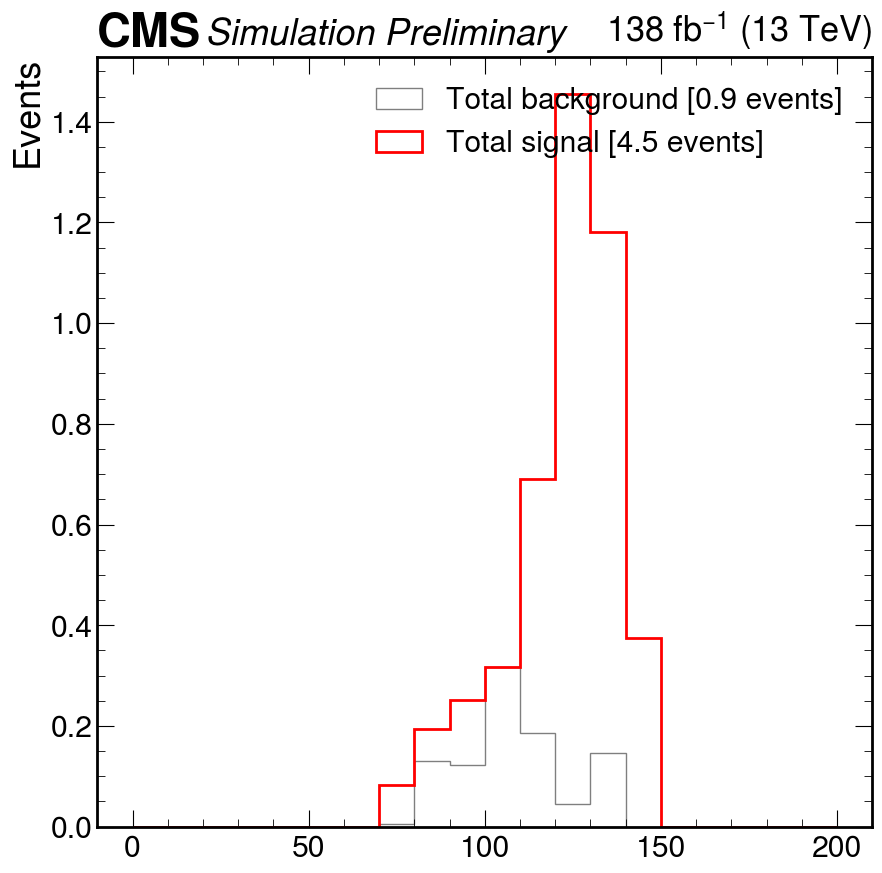

In [70]:
vbsvvh.plot_sig_vs_bkg("hbbfatjet_mass", np.linspace(0, 200, 21), selection=bf_rounded_SR)

<AxesSubplot:ylabel='Events'>

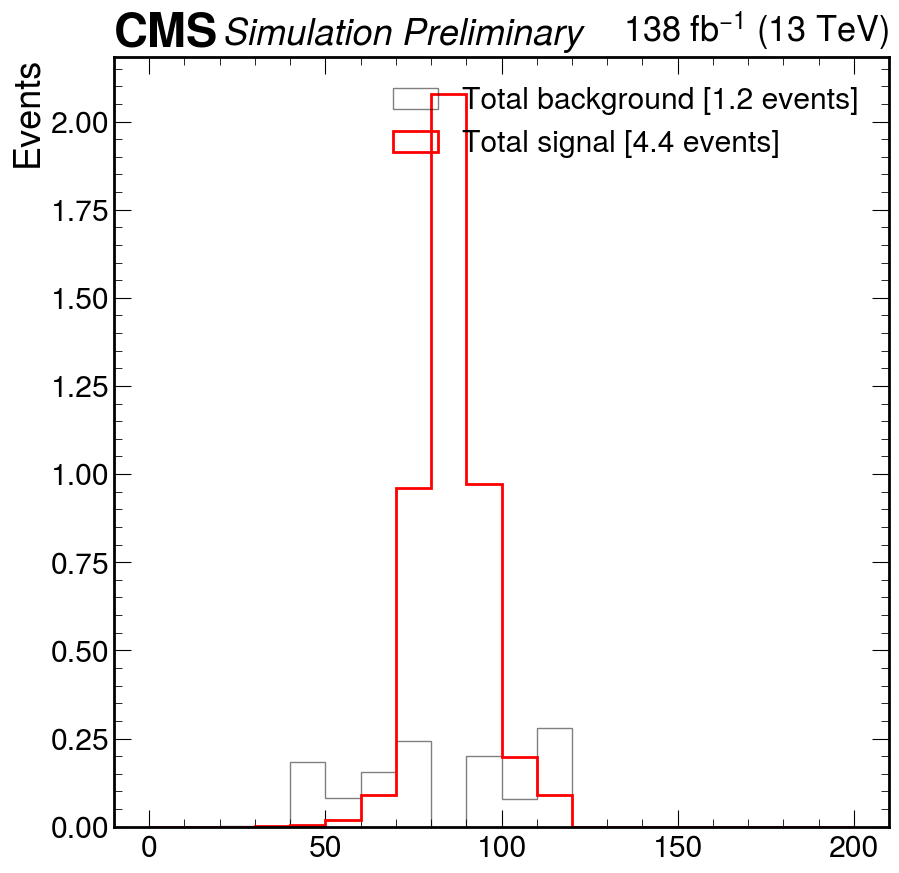

In [36]:
vbsvvh.plot_sig_vs_bkg("ld_vqqfatjet_mass", np.linspace(0, 200, 21), selection=bf_rounded_SR)

<AxesSubplot:ylabel='Events'>

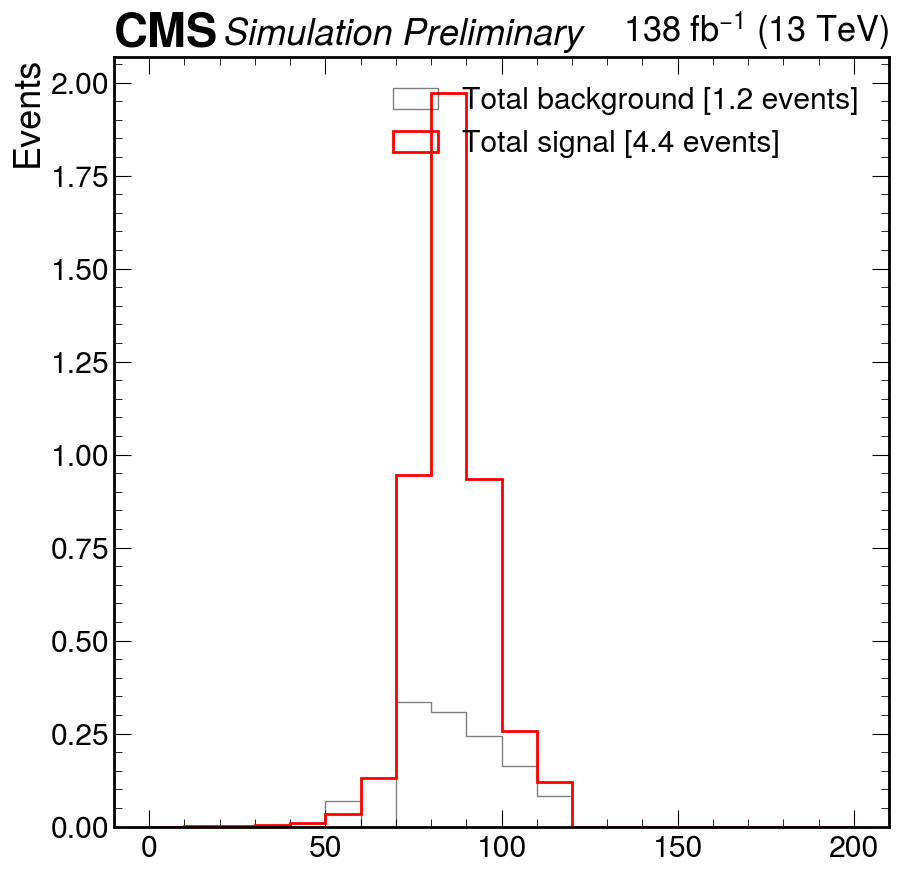

In [37]:
vbsvvh.plot_sig_vs_bkg("tr_vqqfatjet_mass", np.linspace(0, 200, 21), selection=bf_rounded_SR)

In [15]:
vbsvvh.df["SR"] = vbsvvh.df.eval(bf_rounded_SR)

In [16]:
vbsvvh.make_selection("SR")

update_cutflows("SR")

In [17]:
cutflows.reorder(["QCD", "TTHad", "TT1L", "TTW", "TTH", "SingleTop", "Bosons", "TotalBkg", "VBSVVH"])
cutflows.write_csv("test.csv", cutflows.terminal_cut_names[-1])